# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:15:04     -302.231322        4.090922


BFGS:    1 21:15:05     -302.624083        3.108727


BFGS:    2 21:15:05     -303.510837        3.124407


BFGS:    3 21:15:05     -303.665375        2.677381


BFGS:    4 21:15:05     -303.874577        2.581666


BFGS:    5 21:15:05     -303.942974        0.866590


BFGS:    6 21:15:05     -303.979870        0.680259


BFGS:    7 21:15:05     -304.086134        0.647965


BFGS:    8 21:15:05     -304.106870        0.523525


BFGS:    9 21:15:05     -304.140460        0.483604


BFGS:   10 21:15:05     -304.159266        0.270807


BFGS:   11 21:15:05     -304.166766        0.172951


BFGS:   12 21:15:05     -304.169965        0.121396


BFGS:   13 21:15:06     -304.171482        0.106572


BFGS:   14 21:15:06     -304.172648        0.082644


BFGS:   15 21:15:06     -304.173702        0.073229


BFGS:   16 21:15:06     -304.174378        0.076470


BFGS:   17 21:15:06     -304.174916        0.072726


BFGS:   18 21:15:06     -304.175494        0.072577


BFGS:   19 21:15:06     -304.176125        0.074313


BFGS:   20 21:15:06     -304.176823        0.087385


BFGS:   21 21:15:06     -304.177764        0.122745


BFGS:   22 21:15:06     -304.179457        0.167823


BFGS:   23 21:15:06     -304.182823        0.226551


BFGS:   24 21:15:06     -304.189119        0.299285


BFGS:   25 21:15:07     -304.199645        0.425354


BFGS:   26 21:15:07     -304.210921        0.489562


BFGS:   27 21:15:07     -304.233704        0.659032


BFGS:   28 21:15:07     -304.253027        0.609456


BFGS:   29 21:15:07     -304.285151        0.439542


BFGS:   30 21:15:07     -304.301995        0.430050


BFGS:   31 21:15:07     -304.314680        0.387160


BFGS:   32 21:15:07     -304.322081        0.280118


BFGS:   33 21:15:07     -304.332379        0.256651


BFGS:   34 21:15:07     -304.338901        0.194317


BFGS:   35 21:15:07     -304.342888        0.145814


BFGS:   36 21:15:07     -304.344701        0.125411


BFGS:   37 21:15:08     -304.346412        0.115000


BFGS:   38 21:15:08     -304.347852        0.110900


BFGS:   39 21:15:08     -304.350726        0.123114


BFGS:   40 21:15:08     -304.353382        0.095484


BFGS:   41 21:15:08     -304.354746        0.053440


BFGS:   42 21:15:08     -304.355239        0.056015


BFGS:   43 21:15:08     -304.355515        0.059638


BFGS:   44 21:15:08     -304.355826        0.055892


BFGS:   45 21:15:08     -304.356255        0.042630


      Step     Time          Energy          fmax
BFGS:    0 21:15:09     -300.996692        3.985285


BFGS:    1 21:15:09     -301.400256        3.225080


BFGS:    2 21:15:09     -302.586282        3.603003


BFGS:    3 21:15:09     -302.570239        6.398970


BFGS:    4 21:15:09     -302.930338        2.734315


BFGS:    5 21:15:09     -303.089911        0.880352


BFGS:    6 21:15:09     -303.122251        1.133566


BFGS:    7 21:15:09     -303.142407        0.584469


BFGS:    8 21:15:09     -303.163646        0.958799


BFGS:    9 21:15:09     -303.197721        1.058448


BFGS:   10 21:15:09     -303.219786        0.628632


BFGS:   11 21:15:09     -303.228676        0.310489


BFGS:   12 21:15:10     -303.240040        0.528599


BFGS:   13 21:15:10     -303.252924        0.802916


BFGS:   14 21:15:10     -303.272936        0.963510


BFGS:   15 21:15:10     -303.294696        0.981298


BFGS:   16 21:15:10     -303.325587        1.081392


BFGS:   17 21:15:10     -303.424613        2.363248


BFGS:   18 21:15:10     -303.378981        3.584077


BFGS:   19 21:15:10     -303.523080        3.144593


BFGS:   20 21:15:10     -303.605340        3.113704


BFGS:   21 21:15:10     -303.977971        2.661132


BFGS:   22 21:15:10     -304.166531        2.144372


BFGS:   23 21:15:10     -304.231997        1.243294


BFGS:   24 21:15:11     -304.290218        0.830344


BFGS:   25 21:15:11     -304.363359        1.039835


BFGS:   26 21:15:11     -304.458950        1.297588


BFGS:   27 21:15:11     -304.506932        0.797805


BFGS:   28 21:15:11     -304.533669        0.452428


BFGS:   29 21:15:11     -304.557996        0.578042


BFGS:   30 21:15:11     -304.581840        0.563324


BFGS:   31 21:15:11     -304.600819        0.378203


BFGS:   32 21:15:11     -304.611723        0.343577


BFGS:   33 21:15:11     -304.623660        0.375503


BFGS:   34 21:15:11     -304.636976        0.453751


BFGS:   35 21:15:11     -304.651221        0.450846


BFGS:   36 21:15:12     -304.664486        0.293463


BFGS:   37 21:15:12     -304.671492        0.201079


BFGS:   38 21:15:12     -304.675555        0.281416


BFGS:   39 21:15:12     -304.680505        0.327300


BFGS:   40 21:15:12     -304.685332        0.251091


BFGS:   41 21:15:12     -304.688666        0.125706


BFGS:   42 21:15:12     -304.690069        0.072223


BFGS:   43 21:15:12     -304.690556        0.053191


BFGS:   44 21:15:12     -304.690865        0.053697


BFGS:   45 21:15:12     -304.691227        0.050990


BFGS:   46 21:15:12     -304.691705        0.045963


      Step     Time          Energy          fmax
BFGS:    0 21:15:12     -301.388224        4.091972


BFGS:    1 21:15:13     -301.769357        3.466395


BFGS:    2 21:15:13     -302.794360        3.212199


BFGS:    3 21:15:13     -302.846557        5.566366


BFGS:    4 21:15:13     -303.187634        2.473074


BFGS:    5 21:15:13     -303.407898        1.531506


BFGS:    6 21:15:13     -303.594865        3.005491


BFGS:    7 21:15:13     -303.837898        2.159651


BFGS:    8 21:15:13     -303.892828        1.339839


BFGS:    9 21:15:13     -303.986651        0.810832


BFGS:   10 21:15:13     -304.039402        0.733800


BFGS:   11 21:15:13     -304.073984        0.783780


BFGS:   12 21:15:14     -304.105124        0.556592


BFGS:   13 21:15:14     -304.125161        0.382886


BFGS:   14 21:15:14     -304.142574        0.387822


BFGS:   15 21:15:14     -304.153258        0.312443


BFGS:   16 21:15:14     -304.160306        0.286890


BFGS:   17 21:15:14     -304.164684        0.198958


BFGS:   18 21:15:14     -304.167258        0.175803


BFGS:   19 21:15:14     -304.169260        0.149378


BFGS:   20 21:15:14     -304.171883        0.206264


BFGS:   21 21:15:14     -304.175631        0.297203


BFGS:   22 21:15:14     -304.180338        0.302863


BFGS:   23 21:15:14     -304.184632        0.187224


BFGS:   24 21:15:15     -304.188274        0.215717


BFGS:   25 21:15:15     -304.193534        0.316220


BFGS:   26 21:15:15     -304.235834        1.241968


BFGS:   27 21:15:15     -304.342845        0.897090


BFGS:   28 21:15:15     -304.343326        1.128840


BFGS:   29 21:15:15     -304.400980        0.748156


BFGS:   30 21:15:15     -304.439581        0.581804


BFGS:   31 21:15:15     -304.500902        1.105458


BFGS:   32 21:15:15     -304.534976        1.151833


BFGS:   33 21:15:15     -304.575880        0.561992


BFGS:   34 21:15:15     -304.597579        0.458418


BFGS:   35 21:15:15     -304.627096        0.708615


BFGS:   36 21:15:16     -304.646211        0.705724


BFGS:   37 21:15:16     -304.663399        0.391633


BFGS:   38 21:15:16     -304.671497        0.315122


BFGS:   39 21:15:16     -304.676581        0.244493


BFGS:   40 21:15:16     -304.681824        0.166468


BFGS:   41 21:15:16     -304.686213        0.123016


BFGS:   42 21:15:16     -304.688463        0.081279


BFGS:   43 21:15:16     -304.689392        0.058362


BFGS:   44 21:15:16     -304.689983        0.051863


BFGS:   45 21:15:16     -304.690522        0.056015


BFGS:   46 21:15:16     -304.691082        0.054104


BFGS:   47 21:15:16     -304.691610        0.044788


      Step     Time          Energy          fmax
BFGS:    0 21:15:17     -300.788480        3.969275


BFGS:    1 21:15:17     -301.221148        3.615757


BFGS:    2 21:15:17     -302.548347        3.639710


BFGS:    3 21:15:17     -302.358499        8.675445


BFGS:    4 21:15:17     -302.854245        3.054242


BFGS:    5 21:15:17     -303.016311        2.063905


BFGS:    6 21:15:17     -303.107605        2.010928


BFGS:    7 21:15:17     -303.134464        0.503201


BFGS:    8 21:15:17     -303.141847        0.322520


BFGS:    9 21:15:17     -303.158905        0.670348


BFGS:   10 21:15:17     -303.170635        0.632537


BFGS:   11 21:15:17     -303.178297        0.330135


BFGS:   12 21:15:18     -303.180552        0.183327


BFGS:   13 21:15:18     -303.184655        0.395909


BFGS:   14 21:15:18     -303.190209        0.545283


BFGS:   15 21:15:18     -303.197515        0.543310


BFGS:   16 21:15:18     -303.203232        0.349242


BFGS:   17 21:15:18     -303.206158        0.152051


BFGS:   18 21:15:18     -303.207570        0.179332


BFGS:   19 21:15:18     -303.209625        0.267842


BFGS:   20 21:15:18     -303.213332        0.337170


BFGS:   21 21:15:18     -303.217852        0.321725


BFGS:   22 21:15:18     -303.221639        0.238502


BFGS:   23 21:15:18     -303.229738        0.402100


BFGS:   24 21:15:19     -303.238411        1.656979


BFGS:   25 21:15:19     -303.253988        1.331796


BFGS:   26 21:15:19     -303.278105        2.310459


BFGS:   27 21:15:19     -303.293463        3.298160


BFGS:   28 21:15:19     -303.347257        3.054237


BFGS:   29 21:15:19     -303.411210        2.903010


BFGS:   30 21:15:19     -303.512397        2.740968


BFGS:   31 21:15:19     -303.585016        2.202101


BFGS:   32 21:15:19     -303.638893        1.206614


BFGS:   33 21:15:19     -303.701463        0.985206


BFGS:   34 21:15:19     -303.793097        1.170571


BFGS:   35 21:15:19     -303.868646        1.130328


BFGS:   36 21:15:20     -303.922234        1.003786


BFGS:   37 21:15:20     -303.979319        0.809009


BFGS:   38 21:15:20     -304.048639        0.616078


BFGS:   39 21:15:20     -304.101292        0.497186


BFGS:   40 21:15:20     -304.132361        0.344804


BFGS:   41 21:15:20     -304.153133        0.241062


BFGS:   42 21:15:20     -304.163122        0.210470


BFGS:   43 21:15:20     -304.167606        0.191840


BFGS:   44 21:15:20     -304.171977        0.176180


BFGS:   45 21:15:20     -304.178321        0.162044


BFGS:   46 21:15:20     -304.184034        0.160703


BFGS:   47 21:15:20     -304.187755        0.164500


BFGS:   48 21:15:21     -304.190193        0.164517


BFGS:   49 21:15:21     -304.193211        0.164521


BFGS:   50 21:15:21     -304.198778        0.248563


BFGS:   51 21:15:21     -304.207956        0.372880


BFGS:   52 21:15:21     -304.219597        0.439730


BFGS:   53 21:15:21     -304.231551        0.388286


BFGS:   54 21:15:21     -304.245573        0.383700


BFGS:   55 21:15:21     -304.261577        0.356139


BFGS:   56 21:15:21     -304.279520        0.933694


BFGS:   57 21:15:21     -304.299870        0.448310


BFGS:   58 21:15:21     -304.323216        0.281361


BFGS:   59 21:15:21     -304.339594        0.239870


BFGS:   60 21:15:22     -304.343587        0.144064


BFGS:   61 21:15:22     -304.348384        0.101608


BFGS:   62 21:15:22     -304.350876        0.092748


BFGS:   63 21:15:22     -304.352859        0.080505


BFGS:   64 21:15:22     -304.354287        0.059772


BFGS:   65 21:15:22     -304.355259        0.045557


      Step     Time          Energy          fmax
BFGS:    0 21:15:22     -301.864247        4.105310


BFGS:    1 21:15:22     -302.247774        3.517128


BFGS:    2 21:15:22     -303.209070        2.943237


BFGS:    3 21:15:22     -303.331051        3.012078


BFGS:    4 21:15:22     -303.545860        2.025562


BFGS:    5 21:15:23     -303.740784        2.611728


BFGS:    6 21:15:23     -303.815271        1.436320


BFGS:    7 21:15:23     -303.919154        0.885396


BFGS:    8 21:15:23     -303.946181        0.793547


BFGS:    9 21:15:23     -304.024920        0.899611


BFGS:   10 21:15:23     -304.062053        0.901054


BFGS:   11 21:15:23     -304.099186        0.531142


BFGS:   12 21:15:23     -304.114650        0.332410


BFGS:   13 21:15:23     -304.126942        0.415353


BFGS:   14 21:15:23     -304.144972        0.442100


BFGS:   15 21:15:23     -304.156073        0.309534


BFGS:   16 21:15:23     -304.160585        0.175579


BFGS:   17 21:15:24     -304.164617        0.217905


BFGS:   18 21:15:24     -304.169812        0.318473


BFGS:   19 21:15:24     -304.176050        0.328640


BFGS:   20 21:15:24     -304.181443        0.230632


BFGS:   21 21:15:24     -304.185223        0.173853


BFGS:   22 21:15:24     -304.187947        0.171519


BFGS:   23 21:15:24     -304.190641        0.229103


BFGS:   24 21:15:24     -304.194401        0.214616


BFGS:   25 21:15:24     -304.197858        0.188011


BFGS:   26 21:15:24     -304.201216        0.214998


BFGS:   27 21:15:24     -304.206683        0.273881


BFGS:   28 21:15:24     -304.218534        0.522382


BFGS:   29 21:15:25     -304.230507        0.848070


BFGS:   30 21:15:25     -304.252292        0.723184


BFGS:   31 21:15:25     -304.281102        0.450772


BFGS:   32 21:15:25     -304.309711        0.645764


BFGS:   33 21:15:25     -304.322278        0.400570


BFGS:   34 21:15:25     -304.332031        0.254136


BFGS:   35 21:15:25     -304.343699        0.175989


BFGS:   36 21:15:25     -304.346440        0.138081


BFGS:   37 21:15:25     -304.348449        0.134147


BFGS:   38 21:15:25     -304.350005        0.127004


BFGS:   39 21:15:25     -304.351671        0.098693


BFGS:   40 21:15:25     -304.353253        0.073572


BFGS:   41 21:15:26     -304.354761        0.074519


BFGS:   42 21:15:26     -304.355974        0.061903


BFGS:   43 21:15:26     -304.356560        0.040199


      Step     Time          Energy          fmax
BFGS:    0 21:15:26     -302.634928        3.721267


BFGS:    1 21:15:26     -302.985552        2.594305


BFGS:    2 21:15:26     -303.755754        3.130900


BFGS:    3 21:15:26     -303.895139        2.467537


BFGS:    4 21:15:26     -304.043101        3.270387


BFGS:    5 21:15:26     -304.138717        0.812258


BFGS:    6 21:15:26     -304.180229        0.717051


BFGS:    7 21:15:26     -304.308957        0.473882


BFGS:    8 21:15:26     -304.320243        0.425302


BFGS:    9 21:15:27     -304.333731        0.353124


BFGS:   10 21:15:27     -304.342829        0.219122


BFGS:   11 21:15:27     -304.348411        0.137423


BFGS:   12 21:15:27     -304.349860        0.085522


BFGS:   13 21:15:27     -304.350553        0.087047


BFGS:   14 21:15:27     -304.352265        0.133154


BFGS:   15 21:15:27     -304.353267        0.114192


BFGS:   16 21:15:27     -304.353843        0.069185


BFGS:   17 21:15:27     -304.354096        0.063645


BFGS:   18 21:15:27     -304.354450        0.074653


BFGS:   19 21:15:27     -304.355045        0.101846


BFGS:   20 21:15:27     -304.355756        0.108430


BFGS:   21 21:15:28     -304.356236        0.070214


BFGS:   22 21:15:28     -304.356456        0.045053


      Step     Time          Energy          fmax
BFGS:    0 21:15:28     -300.648179        4.006268


BFGS:    1 21:15:28     -301.115835        3.972160


BFGS:    2 21:15:28     -302.522084        3.708474


BFGS:    3 21:15:28     -302.241980        9.684759


BFGS:    4 21:15:28     -302.801889        3.286616


BFGS:    5 21:15:28     -302.959398        2.594109


BFGS:    6 21:15:28     -303.085288        2.831547


BFGS:    7 21:15:28     -303.141207        0.605260


BFGS:    8 21:15:28     -303.148643        0.307076


BFGS:    9 21:15:29     -303.155309        0.285224


BFGS:   10 21:15:29     -303.162179        0.382374


BFGS:   11 21:15:29     -303.171110        0.355756


BFGS:   12 21:15:29     -303.174078        0.225454


BFGS:   13 21:15:29     -303.175467        0.141314


BFGS:   14 21:15:29     -303.178125        0.211179


BFGS:   15 21:15:29     -303.181265        0.279414


BFGS:   16 21:15:29     -303.185167        0.258421


BFGS:   17 21:15:29     -303.187597        0.143697


BFGS:   18 21:15:29     -303.188418        0.110367


BFGS:   19 21:15:29     -303.188772        0.108314


BFGS:   20 21:15:29     -303.189338        0.109043


BFGS:   21 21:15:30     -303.189938        0.086947


BFGS:   22 21:15:30     -303.190252        0.038883


      Step     Time          Energy          fmax
BFGS:    0 21:15:30     -301.043138        4.031590


BFGS:    1 21:15:30     -301.440565        3.103129


BFGS:    2 21:15:30     -302.565356        3.650878


BFGS:    3 21:15:30     -302.641371        5.041988


BFGS:    4 21:15:30     -302.960584        2.440319


BFGS:    5 21:15:30     -303.062576        2.539766


BFGS:    6 21:15:30     -303.108048        0.555338


BFGS:    7 21:15:30     -303.123880        0.482550


BFGS:    8 21:15:30     -303.209033        0.744145


BFGS:    9 21:15:30     -303.222599        0.464696


BFGS:   10 21:15:31     -303.231500        0.325860


BFGS:   11 21:15:31     -303.245742        0.485484


BFGS:   12 21:15:31     -303.259750        0.602157


BFGS:   13 21:15:31     -303.273387        0.631085


BFGS:   14 21:15:31     -303.286715        0.669183


BFGS:   15 21:15:31     -303.308149        0.885166


BFGS:   16 21:15:31     -303.426001        2.242057


BFGS:   17 21:15:31     -303.672658        2.325395


BFGS:   18 21:15:31     -303.470647        4.771194


BFGS:   19 21:15:31     -303.875626        1.245089


BFGS:   20 21:15:31     -303.973700        0.935600


BFGS:   21 21:15:31     -304.100138        0.599645


BFGS:   22 21:15:32     -304.114792        0.492085


BFGS:   23 21:15:32     -304.137768        0.468223


BFGS:   24 21:15:32     -304.151320        0.459236


BFGS:   25 21:15:32     -304.170923        0.379530


BFGS:   26 21:15:32     -304.181716        0.312157


BFGS:   27 21:15:32     -304.195178        0.458381


BFGS:   28 21:15:32     -304.210630        0.560934


BFGS:   29 21:15:32     -304.238924        0.657692


BFGS:   30 21:15:32     -304.285688        1.024119


BFGS:   31 21:15:32     -304.316363        1.229845


BFGS:   32 21:15:32     -304.398055        1.237569


BFGS:   33 21:15:32     -304.476320        0.850454


BFGS:   34 21:15:33     -304.513785        0.659690


BFGS:   35 21:15:33     -304.538666        0.420422


BFGS:   36 21:15:33     -304.560201        0.865950


BFGS:   37 21:15:33     -304.588248        0.777350


BFGS:   38 21:15:33     -304.616778        0.809123


BFGS:   39 21:15:33     -304.632449        0.371991


BFGS:   40 21:15:33     -304.642006        0.292387


BFGS:   41 21:15:33     -304.650057        0.359565


BFGS:   42 21:15:33     -304.657745        0.388244


BFGS:   43 21:15:33     -304.667371        0.323485


BFGS:   44 21:15:33     -304.674273        0.201154


BFGS:   45 21:15:33     -304.677848        0.162674


BFGS:   46 21:15:34     -304.681235        0.188848


BFGS:   47 21:15:34     -304.684180        0.176927


BFGS:   48 21:15:34     -304.686485        0.153064


BFGS:   49 21:15:34     -304.688827        0.128506


BFGS:   50 21:15:34     -304.690629        0.068971


BFGS:   51 21:15:34     -304.691313        0.034236


      Step     Time          Energy          fmax
BFGS:    0 21:15:34     -300.741020        4.046390


BFGS:    1 21:15:34     -301.170245        3.507227


BFGS:    2 21:15:34     -302.463218        3.644927


BFGS:    3 21:15:34     -302.212347        9.488529


BFGS:    4 21:15:34     -302.782370        3.074333


BFGS:    5 21:15:35     -302.955835        2.141846


BFGS:    6 21:15:35     -303.075099        2.352303


BFGS:    7 21:15:35     -303.116636        0.704536


BFGS:    8 21:15:35     -303.130374        0.550292


BFGS:    9 21:15:35     -303.166728        0.708245


BFGS:   10 21:15:35     -303.176362        0.416039


BFGS:   11 21:15:35     -303.179857        0.156242


BFGS:   12 21:15:35     -303.180767        0.156177


BFGS:   13 21:15:35     -303.183429        0.340386


BFGS:   14 21:15:35     -303.185824        0.359014


BFGS:   15 21:15:35     -303.187620        0.217393


BFGS:   16 21:15:35     -303.188376        0.082764


BFGS:   17 21:15:36     -303.188847        0.138757


BFGS:   18 21:15:36     -303.189587        0.191183


BFGS:   19 21:15:36     -303.190638        0.192694


BFGS:   20 21:15:36     -303.191393        0.114480


BFGS:   21 21:15:36     -303.191649        0.032067


      Step     Time          Energy          fmax
BFGS:    0 21:15:36     -301.108872        4.034043


BFGS:    1 21:15:36     -301.502459        3.024349


BFGS:    2 21:15:36     -302.600535        3.644647


BFGS:    3 21:15:36     -302.698297        4.544209


BFGS:    4 21:15:36     -303.004584        2.312471


BFGS:    5 21:15:36     -303.076565        2.664687


BFGS:    6 21:15:36     -303.133805        0.578130


BFGS:    7 21:15:37     -303.150464        0.546783


BFGS:    8 21:15:37     -303.274848        0.544834


BFGS:    9 21:15:37     -303.293426        0.548899


BFGS:   10 21:15:37     -303.353801        0.898926


BFGS:   11 21:15:37     -303.431529        1.632451


BFGS:   12 21:15:37     -303.533519        2.044074


BFGS:   13 21:15:37     -303.670258        1.906072


BFGS:   14 21:15:37     -303.767739        1.631198


BFGS:   15 21:15:37     -303.935450        1.108562


BFGS:   16 21:15:37     -304.031876        1.554244


BFGS:   17 21:15:37     -304.077185        0.772014


BFGS:   18 21:15:37     -304.106830        0.637422


BFGS:   19 21:15:38     -304.127734        0.513282


BFGS:   20 21:15:38     -304.139265        0.460790


BFGS:   21 21:15:38     -304.154241        0.342638


BFGS:   22 21:15:38     -304.164037        0.194737


BFGS:   23 21:15:38     -304.169897        0.173081


BFGS:   24 21:15:38     -304.173058        0.182105


BFGS:   25 21:15:38     -304.177370        0.217642


BFGS:   26 21:15:38     -304.186414        0.267654


BFGS:   27 21:15:38     -304.201145        0.331046


BFGS:   28 21:15:38     -304.222558        0.505452


BFGS:   29 21:15:38     -304.237141        0.833240


BFGS:   30 21:15:38     -304.266939        0.702739


BFGS:   31 21:15:39     -304.328663        0.766129


BFGS:   32 21:15:39     -304.412752        0.801776


BFGS:   33 21:15:39     -304.455378        0.583243


BFGS:   34 21:15:39     -304.478290        0.560411


BFGS:   35 21:15:39     -304.520110        0.596899


BFGS:   36 21:15:39     -304.557344        0.603710


BFGS:   37 21:15:39     -304.599739        0.601897


BFGS:   38 21:15:39     -304.620244        0.378196


BFGS:   39 21:15:39     -304.632513        0.360415


BFGS:   40 21:15:39     -304.641784        0.351190


BFGS:   41 21:15:39     -304.654329        0.340854


BFGS:   42 21:15:39     -304.667677        0.312936


BFGS:   43 21:15:40     -304.677509        0.217642


BFGS:   44 21:15:40     -304.682385        0.211540


BFGS:   45 21:15:40     -304.684991        0.167256


BFGS:   46 21:15:40     -304.686725        0.121907


BFGS:   47 21:15:40     -304.688498        0.095291


BFGS:   48 21:15:40     -304.690321        0.072765


BFGS:   49 21:15:40     -304.691391        0.037392


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:15:40     -296.703405        4.476725


BFGS:    1 21:15:40     -297.172788        4.682154


BFGS:    2 21:15:40     -298.514339        3.634409


BFGS:    3 21:15:40     -298.604169        6.446391


BFGS:    4 21:15:41     -298.928713        1.998212


BFGS:    5 21:15:41     -299.039097        1.802575


BFGS:    6 21:15:41     -299.442837        1.877723


BFGS:    7 21:15:41     -299.622672        1.798517


BFGS:    8 21:15:41     -299.688881        1.291876


BFGS:    9 21:15:41     -299.787786        0.706544


BFGS:   10 21:15:41     -299.828632        0.809560


BFGS:   11 21:15:41     -299.861111        0.767976


BFGS:   12 21:15:41     -299.884562        0.502913


BFGS:   13 21:15:41     -299.896331        0.227496


BFGS:   14 21:15:41     -299.901007        0.239654


BFGS:   15 21:15:41     -299.905926        0.219959


BFGS:   16 21:15:42     -299.910180        0.174530


BFGS:   17 21:15:42     -299.911790        0.116114


BFGS:   18 21:15:42     -299.912319        0.104548


BFGS:   19 21:15:42     -299.913189        0.126191


BFGS:   20 21:15:42     -299.915110        0.224671


BFGS:   21 21:15:42     -299.918992        0.440335


BFGS:   22 21:15:42     -299.923897        0.512921


BFGS:   23 21:15:42     -299.953641        0.830197


BFGS:   24 21:15:42     -300.093453        1.143710


BFGS:   25 21:15:42     -300.295940        1.483506


BFGS:   26 21:15:42     -300.373745        1.100910


BFGS:   27 21:15:42     -300.434031        0.902017


BFGS:   28 21:15:43     -300.476074        0.719875


BFGS:   29 21:15:43     -300.523768        0.760725


BFGS:   30 21:15:43     -300.569417        0.717334


BFGS:   31 21:15:43     -300.599915        0.433764


BFGS:   32 21:15:43     -300.611678        0.212577


BFGS:   33 21:15:43     -300.615411        0.131615


BFGS:   34 21:15:43     -300.617608        0.135303


BFGS:   35 21:15:43     -300.619711        0.157270


BFGS:   36 21:15:43     -300.621826        0.144719


BFGS:   37 21:15:43     -300.623380        0.099112


BFGS:   38 21:15:43     -300.624079        0.057476


BFGS:   39 21:15:43     -300.624419        0.039364


      Step     Time          Energy          fmax
BFGS:    0 21:15:44     -296.227185        4.388564


BFGS:    1 21:15:44     -296.718194        4.686564


BFGS:    2 21:15:44     -298.234242        3.284145


BFGS:    3 21:15:44     -297.538747       11.837795


BFGS:    4 21:15:44     -298.466356        1.904902


BFGS:    5 21:15:44     -298.535061        1.110851


BFGS:    6 21:15:44     -298.585341        1.090490


BFGS:    7 21:15:44     -298.604696        1.013982


BFGS:    8 21:15:44     -298.725367        1.425699


BFGS:    9 21:15:44     -298.777426        1.538441


BFGS:   10 21:15:44     -299.300666        1.962889


BFGS:   11 21:15:44     -299.692311        1.758233


BFGS:   12 21:15:45     -299.687003        2.567458


BFGS:   13 21:15:45     -299.772822        1.346986


BFGS:   14 21:15:45     -299.819365        0.990232


BFGS:   15 21:15:45     -299.962677        1.089935


BFGS:   16 21:15:45     -300.020542        1.114164


BFGS:   17 21:15:45     -300.112961        1.288586


BFGS:   18 21:15:45     -300.206516        1.533029


BFGS:   19 21:15:45     -300.300599        1.494746


BFGS:   20 21:15:45     -300.390480        1.454542


BFGS:   21 21:15:45     -300.471750        0.808271


BFGS:   22 21:15:45     -300.532875        0.572752


BFGS:   23 21:15:45     -300.555070        0.523144


BFGS:   24 21:15:46     -300.578253        0.482986


BFGS:   25 21:15:46     -300.599708        0.424539


BFGS:   26 21:15:46     -300.613913        0.234976


BFGS:   27 21:15:46     -300.619050        0.089084


BFGS:   28 21:15:46     -300.620678        0.068086


BFGS:   29 21:15:46     -300.621470        0.090754


BFGS:   30 21:15:46     -300.622302        0.113510


BFGS:   31 21:15:46     -300.623216        0.105295


BFGS:   32 21:15:46     -300.624092        0.067155


BFGS:   33 21:15:47     -300.624653        0.039884


      Step     Time          Energy          fmax
BFGS:    0 21:15:47     -297.338212        4.624831


BFGS:    1 21:15:47     -297.830303        4.721261


BFGS:    2 21:15:47     -299.083841        3.393246


BFGS:    3 21:15:47     -299.286102        4.328407


BFGS:    4 21:15:47     -299.495313        1.276320


BFGS:    5 21:15:47     -299.581006        1.107459


BFGS:    6 21:15:47     -299.770066        0.973351


BFGS:    7 21:15:47     -299.794460        0.729709


BFGS:    8 21:15:47     -299.866501        0.723779


BFGS:    9 21:15:47     -299.890526        0.564135


BFGS:   10 21:15:47     -299.911061        0.411484


BFGS:   11 21:15:48     -299.919860        0.353390


BFGS:   12 21:15:48     -299.927086        0.316460


BFGS:   13 21:15:48     -299.930311        0.288973


BFGS:   14 21:15:48     -299.933649        0.273622


BFGS:   15 21:15:48     -299.937574        0.315815


BFGS:   16 21:15:48     -299.948518        0.528738


BFGS:   17 21:15:48     -299.962648        0.729902


BFGS:   18 21:15:48     -299.979175        0.562264


BFGS:   19 21:15:48     -300.011037        0.356249


BFGS:   20 21:15:48     -300.021295        0.652886


BFGS:   21 21:15:48     -300.044080        0.558497


BFGS:   22 21:15:48     -300.061977        0.337111


BFGS:   23 21:15:49     -300.072519        0.142911


BFGS:   24 21:15:49     -300.074745        0.101436


BFGS:   25 21:15:49     -300.076054        0.095677


BFGS:   26 21:15:49     -300.077644        0.081622


BFGS:   27 21:15:49     -300.079272        0.058994


BFGS:   28 21:15:49     -300.080229        0.036910


      Step     Time          Energy          fmax
BFGS:    0 21:15:49     -296.476262        4.429235


BFGS:    1 21:15:49     -296.949136        4.665854


BFGS:    2 21:15:49     -298.351403        3.474160


BFGS:    3 21:15:49     -298.136776        8.534506


BFGS:    4 21:15:49     -298.663337        1.956241


BFGS:    5 21:15:49     -298.746923        1.437156


BFGS:    6 21:15:50     -298.908587        2.218398


BFGS:    7 21:15:50     -299.124630        2.786336


BFGS:    8 21:15:50     -299.362219        2.462620


BFGS:    9 21:15:50     -299.382204        1.704583


BFGS:   10 21:15:50     -299.522767        1.590083


BFGS:   11 21:15:50     -299.626246        1.205216


BFGS:   12 21:15:50     -299.820324        0.957299


BFGS:   13 21:15:50     -299.867567        0.765081


BFGS:   14 21:15:50     -299.884331        0.521636


BFGS:   15 21:15:50     -299.894991        0.294951


BFGS:   16 21:15:50     -299.901117        0.302377


BFGS:   17 21:15:51     -299.905683        0.252682


BFGS:   18 21:15:51     -299.912416        0.258865


BFGS:   19 21:15:51     -299.916785        0.240817


BFGS:   20 21:15:51     -299.919124        0.238318


BFGS:   21 21:15:51     -299.922071        0.290769


BFGS:   22 21:15:51     -299.929716        0.495231


BFGS:   23 21:15:51     -299.952152        1.180958


BFGS:   24 21:15:51     -299.995431        1.911753


BFGS:   25 21:15:51     -299.956411        2.456544


BFGS:   26 21:15:51     -300.027838        2.022644


BFGS:   27 21:15:51     -300.054728        1.924918


BFGS:   28 21:15:51     -300.342838        0.850418


BFGS:   29 21:15:52     -300.441116        0.785114


BFGS:   30 21:15:52     -300.478760        0.766009


BFGS:   31 21:15:52     -300.550624        0.649427


BFGS:   32 21:15:52     -300.573441        0.519542


BFGS:   33 21:15:52     -300.587200        0.489653


BFGS:   34 21:15:52     -300.597900        0.393781


BFGS:   35 21:15:52     -300.614047        0.171658


BFGS:   36 21:15:52     -300.619960        0.125109


BFGS:   37 21:15:52     -300.621894        0.080031


BFGS:   38 21:15:52     -300.622377        0.098275


BFGS:   39 21:15:52     -300.623473        0.106943


BFGS:   40 21:15:52     -300.624258        0.070870


BFGS:   41 21:15:53     -300.624650        0.037582


      Step     Time          Energy          fmax
BFGS:    0 21:15:53     -296.181655        4.383255


BFGS:    1 21:15:53     -296.678827        4.695548


BFGS:    2 21:15:53     -298.222871        3.241324


BFGS:    3 21:15:53     -297.407411       12.658701


BFGS:    4 21:15:53     -298.442355        1.895591


BFGS:    5 21:15:53     -298.509312        1.080511


BFGS:    6 21:15:53     -298.553523        0.948558


BFGS:    7 21:15:53     -298.566561        0.808265


BFGS:    8 21:15:53     -298.632277        0.900450


BFGS:    9 21:15:53     -298.652816        1.042795


BFGS:   10 21:15:53     -298.769630        1.940588


BFGS:   11 21:15:54     -298.865503        2.765394


BFGS:   12 21:15:54     -298.896335        3.120524


BFGS:   13 21:15:54     -298.931753        3.100385


BFGS:   14 21:15:54     -299.046276        3.231793


BFGS:   15 21:15:54     -299.282683        3.252152


BFGS:   16 21:15:54     -299.400508        3.611246


BFGS:   17 21:15:54     -299.555009        2.756803


BFGS:   18 21:15:54     -299.741960        1.609958


BFGS:   19 21:15:54     -299.838726        0.723021


BFGS:   20 21:15:54     -299.880669        0.703727


BFGS:   21 21:15:54     -299.908647        0.677553


BFGS:   22 21:15:54     -299.943185        0.568963


BFGS:   23 21:15:55     -299.963585        0.591689


BFGS:   24 21:15:55     -299.978944        0.638577


BFGS:   25 21:15:55     -300.003518        0.792660


BFGS:   26 21:15:55     -300.108273        1.345422


BFGS:   27 21:15:55     -300.008656        1.880713


BFGS:   28 21:15:55     -300.180921        1.342934


BFGS:   29 21:15:55     -300.234331        1.304193


BFGS:   30 21:15:55     -300.473654        0.862490


BFGS:   31 21:15:55     -300.502306        0.505965


BFGS:   32 21:15:55     -300.536783        0.571024


BFGS:   33 21:15:55     -300.577845        0.499761


BFGS:   34 21:15:56     -300.602187        0.260209


BFGS:   35 21:15:56     -300.609164        0.220074


BFGS:   36 21:15:56     -300.613603        0.195872


BFGS:   37 21:15:56     -300.618261        0.165337


BFGS:   38 21:15:56     -300.621716        0.117880


BFGS:   39 21:15:56     -300.623591        0.072031


BFGS:   40 21:15:56     -300.624185        0.036673


      Step     Time          Energy          fmax
BFGS:    0 21:15:56     -297.536423        4.524309


BFGS:    1 21:15:56     -298.010107        4.582645


BFGS:    2 21:15:56     -299.199809        3.196156


BFGS:    3 21:15:56     -299.376985        4.188211


BFGS:    4 21:15:56     -299.580982        1.326309


BFGS:    5 21:15:57     -299.675602        1.248938


BFGS:    6 21:15:57     -299.938099        0.921827


BFGS:    7 21:15:57     -299.971427        0.767645


BFGS:    8 21:15:57     -300.037229        0.682945


BFGS:    9 21:15:57     -300.057021        0.453335


BFGS:   10 21:15:57     -300.068381        0.182737


BFGS:   11 21:15:57     -300.070425        0.159565


BFGS:   12 21:15:57     -300.073120        0.139267


BFGS:   13 21:15:57     -300.075201        0.131870


BFGS:   14 21:15:57     -300.076184        0.113648


BFGS:   15 21:15:57     -300.076747        0.103208


BFGS:   16 21:15:57     -300.077494        0.097799


BFGS:   17 21:15:58     -300.078581        0.129028


BFGS:   18 21:15:58     -300.079711        0.119672


BFGS:   19 21:15:58     -300.080414        0.065694


BFGS:   20 21:15:58     -300.080662        0.018107


      Step     Time          Energy          fmax
BFGS:    0 21:15:58     -297.283896        4.786953


BFGS:    1 21:15:58     -297.759951        4.935330


BFGS:    2 21:15:58     -299.027481        4.017990


BFGS:    3 21:15:58     -299.468543        4.055861


BFGS:    4 21:15:58     -299.673784        2.168898


BFGS:    5 21:15:58     -300.064177        2.017284


BFGS:    6 21:15:58     -300.204457        1.458600


BFGS:    7 21:15:58     -300.263650        1.221017


BFGS:    8 21:15:59     -300.352316        1.374986


BFGS:    9 21:15:59     -300.438386        1.221325


BFGS:   10 21:15:59     -300.462796        1.065226


BFGS:   11 21:15:59     -300.491021        1.117787


BFGS:   12 21:15:59     -300.521245        0.920482


BFGS:   13 21:15:59     -300.539293        0.556224


BFGS:   14 21:15:59     -300.549605        0.593307


BFGS:   15 21:15:59     -300.558116        0.559855


BFGS:   16 21:15:59     -300.565316        0.582293


BFGS:   17 21:15:59     -300.571838        0.578239


BFGS:   18 21:15:59     -300.576289        0.531678


BFGS:   19 21:15:59     -300.578541        0.496267


BFGS:   20 21:16:00     -300.580268        0.474281


BFGS:   21 21:16:00     -300.582183        0.448881


BFGS:   22 21:16:00     -300.583565        0.420698


BFGS:   23 21:16:00     -300.584225        0.409347


BFGS:   24 21:16:00     -300.584581        0.413088


BFGS:   25 21:16:00     -300.584900        0.423191


BFGS:   26 21:16:00     -300.585252        0.432248


BFGS:   27 21:16:00     -300.585665        0.431157


BFGS:   28 21:16:00     -300.585980        0.414185


BFGS:   29 21:16:00     -300.586159        0.394143


BFGS:   30 21:16:00     -300.586265        0.381074


BFGS:   31 21:16:01     -300.586370        0.372039


BFGS:   32 21:16:01     -300.586488        0.368459


BFGS:   33 21:16:01     -300.586593        0.373481


BFGS:   34 21:16:01     -300.586663        0.384184


BFGS:   35 21:16:01     -300.586712        0.394682


BFGS:   36 21:16:01     -300.586763        0.403481


BFGS:   37 21:16:01     -300.586821        0.407467


BFGS:   38 21:16:01     -300.586872        0.403789


BFGS:   39 21:16:01     -300.586907        0.395904


BFGS:   40 21:16:01     -300.586936        0.387894


BFGS:   41 21:16:01     -300.586972        0.380550


BFGS:   42 21:16:01     -300.587018        0.377196


BFGS:   43 21:16:02     -300.587052        0.381406


BFGS:   44 21:16:02     -300.587066        0.388643


BFGS:   45 21:16:02     -300.587073        0.393568


BFGS:   46 21:16:02     -300.587080        0.397347


BFGS:   47 21:16:02     -300.587087        0.399448


BFGS:   48 21:16:02     -300.587093        0.399218


BFGS:   49 21:16:02     -300.587096        0.396438


BFGS:   50 21:16:02     -300.587099        0.393461


BFGS:   51 21:16:02     -300.587101        0.391464


BFGS:   52 21:16:02     -300.587101        0.390121


BFGS:   53 21:16:02     -300.587105        0.389761


BFGS:   54 21:16:02     -300.587106        0.390552


BFGS:   55 21:16:03     -300.587105        0.391802


BFGS:   56 21:16:03     -300.587106        0.392838


BFGS:   57 21:16:03     -300.587103        0.393596


BFGS:   58 21:16:03     -300.587107        0.393987


BFGS:   59 21:16:03     -300.587106        0.393781


BFGS:   60 21:16:03     -300.587106        0.393172


BFGS:   61 21:16:03     -300.587107        0.392688


BFGS:   62 21:16:03     -300.587106        0.392331


BFGS:   63 21:16:03     -300.587106        0.392176


BFGS:   64 21:16:03     -300.587108        0.392113


BFGS:   65 21:16:03     -300.587106        0.392215


BFGS:   66 21:16:04     -300.587106        0.392398


BFGS:   67 21:16:04     -300.587106        0.392577


BFGS:   68 21:16:04     -300.587109        0.392675


BFGS:   69 21:16:04     -300.587106        0.392730


BFGS:   70 21:16:04     -300.587108        0.392637


BFGS:   71 21:16:04     -300.587106        0.392558


BFGS:   72 21:16:04     -300.587106        0.392464


BFGS:   73 21:16:04     -300.587107        0.392396


BFGS:   74 21:16:04     -300.587105        0.392362


BFGS:   75 21:16:04     -300.587107        0.392360


BFGS:   76 21:16:04     -300.587106        0.392411


BFGS:   77 21:16:04     -300.587106        0.392434


BFGS:   78 21:16:05     -300.587106        0.392463


BFGS:   79 21:16:05     -300.587106        0.392499


BFGS:   80 21:16:05     -300.587107        0.392470


BFGS:   81 21:16:05     -300.587106        0.392460


BFGS:   82 21:16:05     -300.587106        0.392420


BFGS:   83 21:16:05     -300.587106        0.392405


BFGS:   84 21:16:05     -300.587108        0.392426


BFGS:   85 21:16:05     -300.587106        0.392430


BFGS:   86 21:16:05     -300.587107        0.392430


BFGS:   87 21:16:05     -300.587105        0.392425


BFGS:   88 21:16:05     -300.587106        0.392439


BFGS:   89 21:16:05     -300.587106        0.392440


BFGS:   90 21:16:06     -300.587107        0.392426


BFGS:   91 21:16:06     -300.587105        0.392445


BFGS:   92 21:16:06     -300.587106        0.392435


BFGS:   93 21:16:06     -300.587106        0.392431


BFGS:   94 21:16:06     -300.587106        0.392440


BFGS:   95 21:16:06     -300.587106        0.392440


BFGS:   96 21:16:06     -300.587107        0.392437


BFGS:   97 21:16:06     -300.587107        0.392438


BFGS:   98 21:16:06     -300.587109        0.392440


BFGS:   99 21:16:06     -300.587106        0.392437


BFGS:  100 21:16:06     -300.587107        0.392442


BFGS:  101 21:16:07     -300.587106        0.392450


BFGS:  102 21:16:07     -300.587106        0.392422


BFGS:  103 21:16:07     -300.587106        0.392443


BFGS:  104 21:16:07     -300.587106        0.392447


BFGS:  105 21:16:07     -300.587106        0.392441


BFGS:  106 21:16:07     -300.587109        0.392430


BFGS:  107 21:16:07     -300.587105        0.392443


BFGS:  108 21:16:07     -300.587108        0.392441


BFGS:  109 21:16:07     -300.587106        0.392436


BFGS:  110 21:16:07     -300.587106        0.392450


BFGS:  111 21:16:07     -300.587106        0.392449


BFGS:  112 21:16:07     -300.587106        0.392441


BFGS:  113 21:16:08     -300.587106        0.392433


BFGS:  114 21:16:08     -300.587107        0.392439


BFGS:  115 21:16:08     -300.587106        0.392443


BFGS:  116 21:16:08     -300.587106        0.392441


BFGS:  117 21:16:08     -300.587106        0.392428


BFGS:  118 21:16:08     -300.587106        0.392435


BFGS:  119 21:16:08     -300.587106        0.392452


BFGS:  120 21:16:08     -300.587107        0.392441


BFGS:  121 21:16:08     -300.587105        0.392431


BFGS:  122 21:16:08     -300.587106        0.392442


BFGS:  123 21:16:08     -300.587105        0.392434


BFGS:  124 21:16:08     -300.587106        0.392438


BFGS:  125 21:16:09     -300.587105        0.392441


BFGS:  126 21:16:09     -300.587108        0.392437


BFGS:  127 21:16:09     -300.587106        0.392440


BFGS:  128 21:16:09     -300.587107        0.392435


BFGS:  129 21:16:09     -300.587105        0.392433


BFGS:  130 21:16:09     -300.587109        0.392422


BFGS:  131 21:16:09     -300.587106        0.392442


BFGS:  132 21:16:09     -300.587108        0.392440


BFGS:  133 21:16:09     -300.587105        0.392436


BFGS:  134 21:16:09     -300.587108        0.392433


BFGS:  135 21:16:09     -300.587106        0.392440


BFGS:  136 21:16:10     -300.587107        0.392440


BFGS:  137 21:16:10     -300.587105        0.392444


BFGS:  138 21:16:10     -300.587108        0.392419


BFGS:  139 21:16:10     -300.587106        0.392438


BFGS:  140 21:16:10     -300.587108        0.392419


BFGS:  141 21:16:10     -300.587105        0.392440


BFGS:  142 21:16:10     -300.587109        0.392442


BFGS:  143 21:16:10     -300.587107        0.392432


BFGS:  144 21:16:10     -300.587107        0.392439


BFGS:  145 21:16:10     -300.587106        0.392445


BFGS:  146 21:16:10     -300.587107        0.392430


BFGS:  147 21:16:10     -300.587107        0.392439


BFGS:  148 21:16:11     -300.587106        0.392442


BFGS:  149 21:16:11     -300.587106        0.392439


BFGS:  150 21:16:11     -300.587106        0.392440


BFGS:  151 21:16:11     -300.587105        0.392429


BFGS:  152 21:16:11     -300.587107        0.392426


BFGS:  153 21:16:11     -300.587105        0.392441


BFGS:  154 21:16:11     -300.587107        0.392437


BFGS:  155 21:16:11     -300.587106        0.392445


BFGS:  156 21:16:11     -300.587106        0.392444


BFGS:  157 21:16:11     -300.587106        0.392433


BFGS:  158 21:16:11     -300.587107        0.392439


BFGS:  159 21:16:11     -300.587105        0.392447


BFGS:  160 21:16:12     -300.587108        0.392419


BFGS:  161 21:16:12     -300.587105        0.392441


BFGS:  162 21:16:12     -300.587107        0.392430


BFGS:  163 21:16:12     -300.587105        0.392424


BFGS:  164 21:16:12     -300.587106        0.392419


BFGS:  165 21:16:12     -300.587106        0.392435


BFGS:  166 21:16:12     -300.587106        0.392430


BFGS:  167 21:16:12     -300.587106        0.392431


BFGS:  168 21:16:12     -300.587106        0.392439


BFGS:  169 21:16:12     -300.587106        0.392436


BFGS:  170 21:16:12     -300.587106        0.392433


BFGS:  171 21:16:12     -300.587105        0.392432


BFGS:  172 21:16:13     -300.587106        0.392420


BFGS:  173 21:16:13     -300.587108        0.392430


BFGS:  174 21:16:13     -300.587107        0.392442


BFGS:  175 21:16:13     -300.587106        0.392440


BFGS:  176 21:16:13     -300.587106        0.392428


BFGS:  177 21:16:13     -300.587105        0.392440


BFGS:  178 21:16:13     -300.587107        0.392424


BFGS:  179 21:16:13     -300.587105        0.392440


BFGS:  180 21:16:13     -300.587106        0.392428


BFGS:  181 21:16:14     -300.587107        0.392432


BFGS:  182 21:16:14     -300.587106        0.392416


BFGS:  183 21:16:14     -300.587106        0.392439


BFGS:  184 21:16:14     -300.587108        0.392424


BFGS:  185 21:16:14     -300.587105        0.392434


BFGS:  186 21:16:14     -300.587108        0.392418


BFGS:  187 21:16:14     -300.587106        0.392442


BFGS:  188 21:16:14     -300.587105        0.392426


BFGS:  189 21:16:14     -300.587105        0.392430


BFGS:  190 21:16:14     -300.587107        0.392440


BFGS:  191 21:16:14     -300.587105        0.392440


BFGS:  192 21:16:14     -300.587107        0.392431


BFGS:  193 21:16:15     -300.587106        0.392430


BFGS:  194 21:16:15     -300.587106        0.392425


BFGS:  195 21:16:15     -300.587106        0.392417


BFGS:  196 21:16:15     -300.587106        0.392444


BFGS:  197 21:16:15     -300.587106        0.392440


BFGS:  198 21:16:15     -300.587108        0.392440


BFGS:  199 21:16:15     -300.587106        0.392430


BFGS:  200 21:16:15     -300.587106        0.392440


BFGS:  201 21:16:15     -300.587106        0.392434


BFGS:  202 21:16:15     -300.587107        0.392434


BFGS:  203 21:16:15     -300.587106        0.392435


BFGS:  204 21:16:15     -300.587107        0.392437


BFGS:  205 21:16:16     -300.587105        0.392435


BFGS:  206 21:16:16     -300.587107        0.392438


BFGS:  207 21:16:16     -300.587106        0.392438


BFGS:  208 21:16:16     -300.587108        0.392440


BFGS:  209 21:16:16     -300.587105        0.392443


BFGS:  210 21:16:16     -300.587107        0.392436


BFGS:  211 21:16:16     -300.587106        0.392443


BFGS:  212 21:16:16     -300.587107        0.392440


BFGS:  213 21:16:16     -300.587105        0.392414


BFGS:  214 21:16:16     -300.587108        0.392440


BFGS:  215 21:16:16     -300.587105        0.392442


BFGS:  216 21:16:16     -300.587107        0.392437


BFGS:  217 21:16:17     -300.587106        0.392433


BFGS:  218 21:16:17     -300.587106        0.392440


BFGS:  219 21:16:17     -300.587107        0.392440


BFGS:  220 21:16:17     -300.587107        0.392435


BFGS:  221 21:16:17     -300.587107        0.392444


BFGS:  222 21:16:17     -300.587107        0.392440


BFGS:  223 21:16:17     -300.587105        0.392439


BFGS:  224 21:16:17     -300.587106        0.392438


BFGS:  225 21:16:17     -300.587106        0.392436


BFGS:  226 21:16:17     -300.587106        0.392444


BFGS:  227 21:16:17     -300.587106        0.392447


BFGS:  228 21:16:18     -300.587106        0.392437


BFGS:  229 21:16:18     -300.587105        0.392436


BFGS:  230 21:16:18     -300.587106        0.392442


BFGS:  231 21:16:18     -300.587106        0.392436


BFGS:  232 21:16:18     -300.587108        0.392416


BFGS:  233 21:16:18     -300.587106        0.392416


BFGS:  234 21:16:18     -300.587108        0.392441


BFGS:  235 21:16:18     -300.587105        0.392437


BFGS:  236 21:16:18     -300.587107        0.392420


BFGS:  237 21:16:18     -300.587106        0.392417


BFGS:  238 21:16:18     -300.587106        0.392431


BFGS:  239 21:16:18     -300.587105        0.392432


BFGS:  240 21:16:19     -300.587106        0.392418


BFGS:  241 21:16:19     -300.587106        0.392417


BFGS:  242 21:16:19     -300.587107        0.392430


BFGS:  243 21:16:19     -300.587106        0.392434


BFGS:  244 21:16:19     -300.587105        0.392434


BFGS:  245 21:16:19     -300.587106        0.392418


BFGS:  246 21:16:19     -300.587106        0.392434


BFGS:  247 21:16:19     -300.587107        0.392442


BFGS:  248 21:16:19     -300.587108        0.392419


BFGS:  249 21:16:19     -300.587106        0.392418


BFGS:  250 21:16:19     -300.587107        0.392432


BFGS:  251 21:16:19     -300.587106        0.392432


BFGS:  252 21:16:20     -300.587106        0.392424


BFGS:  253 21:16:20     -300.587106        0.392418


BFGS:  254 21:16:20     -300.587107        0.392433


BFGS:  255 21:16:20     -300.587106        0.392435


BFGS:  256 21:16:20     -300.587106        0.392431


BFGS:  257 21:16:20     -300.587105        0.392427


BFGS:  258 21:16:20     -300.587107        0.392432


BFGS:  259 21:16:20     -300.587106        0.392441


BFGS:  260 21:16:20     -300.587106        0.392418


BFGS:  261 21:16:20     -300.587105        0.392417


BFGS:  262 21:16:20     -300.587107        0.392433


BFGS:  263 21:16:20     -300.587106        0.392434


BFGS:  264 21:16:21     -300.587108        0.392424


BFGS:  265 21:16:21     -300.587105        0.392417


BFGS:  266 21:16:21     -300.587108        0.392432


BFGS:  267 21:16:21     -300.587105        0.392442


BFGS:  268 21:16:21     -300.587106        0.392427


BFGS:  269 21:16:21     -300.587106        0.392417


BFGS:  270 21:16:21     -300.587106        0.392460


BFGS:  271 21:16:21     -300.587106        0.392430


BFGS:  272 21:16:21     -300.587108        0.392419


BFGS:  273 21:16:21     -300.587106        0.392440


BFGS:  274 21:16:21     -300.587106        0.392442


BFGS:  275 21:16:21     -300.587106        0.392434


BFGS:  276 21:16:22     -300.587106        0.392426


BFGS:  277 21:16:22     -300.587106        0.392416


BFGS:  278 21:16:22     -300.587106        0.392433


BFGS:  279 21:16:22     -300.587105        0.392442


BFGS:  280 21:16:22     -300.587108        0.392437


BFGS:  281 21:16:22     -300.587105        0.392454


BFGS:  282 21:16:22     -300.587107        0.392437


BFGS:  283 21:16:22     -300.587106        0.392440


BFGS:  284 21:16:22     -300.587107        0.392446


BFGS:  285 21:16:22     -300.587106        0.392444


BFGS:  286 21:16:22     -300.587106        0.392398


BFGS:  287 21:16:22     -300.587105        0.392417


BFGS:  288 21:16:23     -300.587108        0.392443


BFGS:  289 21:16:23     -300.587105        0.392437


BFGS:  290 21:16:23     -300.587106        0.392443


BFGS:  291 21:16:23     -300.587105        0.392440


BFGS:  292 21:16:23     -300.587106        0.392441


BFGS:  293 21:16:23     -300.587106        0.392443


BFGS:  294 21:16:23     -300.587107        0.392450


BFGS:  295 21:16:23     -300.587106        0.392441


BFGS:  296 21:16:23     -300.587107        0.392415


BFGS:  297 21:16:23     -300.587106        0.392435


BFGS:  298 21:16:23     -300.587108        0.392438


BFGS:  299 21:16:24     -300.587105        0.392422


BFGS:  300 21:16:24     -300.587106        0.392432


      Step     Time          Energy          fmax
BFGS:    0 21:16:24     -296.274934        4.392612


BFGS:    1 21:16:24     -296.759585        4.677115


BFGS:    2 21:16:24     -298.248365        3.326778


BFGS:    3 21:16:24     -297.668356       11.047702


BFGS:    4 21:16:24     -298.494541        1.914279


BFGS:    5 21:16:24     -298.565366        1.150795


BFGS:    6 21:16:24     -298.624560        1.263935


BFGS:    7 21:16:24     -298.654245        1.274704


BFGS:    8 21:16:24     -298.839740        1.396851


BFGS:    9 21:16:24     -298.938084        2.144229


BFGS:   10 21:16:25     -299.097894        2.408708


BFGS:   11 21:16:25     -299.297610        2.468896


BFGS:   12 21:16:25     -299.672065        1.798885


BFGS:   13 21:16:25     -299.898238        1.442069


BFGS:   14 21:16:25     -300.022699        0.964316


BFGS:   15 21:16:25     -300.055774        1.002156


BFGS:   16 21:16:25     -300.261701        1.598760


BFGS:   17 21:16:25     -300.350202        1.472553


BFGS:   18 21:16:25     -300.413627        1.143049


BFGS:   19 21:16:25     -300.481125        0.782400


BFGS:   20 21:16:25     -300.514941        0.609132


BFGS:   21 21:16:25     -300.552457        0.634330


BFGS:   22 21:16:26     -300.584748        0.476511


BFGS:   23 21:16:26     -300.598617        0.358082


BFGS:   24 21:16:26     -300.606564        0.248334


BFGS:   25 21:16:26     -300.612204        0.232171


BFGS:   26 21:16:26     -300.617090        0.215997


BFGS:   27 21:16:26     -300.620901        0.163581


BFGS:   28 21:16:26     -300.622853        0.089108


BFGS:   29 21:16:26     -300.623497        0.056834


BFGS:   30 21:16:26     -300.623871        0.041746


      Step     Time          Energy          fmax
BFGS:    0 21:16:26     -297.630787        4.917477


BFGS:    1 21:16:26     -298.128041        4.986328


BFGS:    2 21:16:26     -299.333635        3.818708


BFGS:    3 21:16:27     -299.811279        2.853715


BFGS:    4 21:16:27     -299.959100        1.998864


BFGS:    5 21:16:27     -300.366101        1.145207


BFGS:    6 21:16:27     -300.436669        0.976255


BFGS:    7 21:16:27     -300.509943        1.065213


BFGS:    8 21:16:27     -300.567013        0.720483


BFGS:    9 21:16:27     -300.598478        0.401960


BFGS:   10 21:16:27     -300.609193        0.351364


BFGS:   11 21:16:27     -300.615575        0.255072


BFGS:   12 21:16:27     -300.618995        0.154363


BFGS:   13 21:16:27     -300.621148        0.096361


BFGS:   14 21:16:27     -300.621808        0.081289


BFGS:   15 21:16:28     -300.622265        0.090938


BFGS:   16 21:16:28     -300.622999        0.110332


BFGS:   17 21:16:28     -300.623903        0.100059


BFGS:   18 21:16:28     -300.624561        0.053695


BFGS:   19 21:16:28     -300.624815        0.032212


      Step     Time          Energy          fmax
BFGS:    0 21:16:28     -296.399997        4.417413


BFGS:    1 21:16:28     -296.872966        4.673161


BFGS:    2 21:16:28     -298.299614        3.443996


BFGS:    3 21:16:28     -297.991673        9.185773


BFGS:    4 21:16:28     -298.590293        1.938586


BFGS:    5 21:16:28     -298.668439        1.303222


BFGS:    6 21:16:28     -298.773986        1.847919


BFGS:    7 21:16:29     -298.876492        2.241794


BFGS:    8 21:16:29     -299.135634        2.397980


BFGS:    9 21:16:29     -299.324592        2.088454


BFGS:   10 21:16:29     -299.380562        1.744910


BFGS:   11 21:16:29     -299.519087        1.585612


BFGS:   12 21:16:29     -299.914339        1.647724


BFGS:   13 21:16:29     -300.233813        1.343483


BFGS:   14 21:16:29     -300.313634        1.517462


BFGS:   15 21:16:29     -300.375133        1.399717


BFGS:   16 21:16:29     -300.444140        2.197584


BFGS:   17 21:16:29     -300.540364        0.651576


BFGS:   18 21:16:30     -300.556083        0.413302


BFGS:   19 21:16:30     -300.575690        0.627992


BFGS:   20 21:16:30     -300.588707        0.589206


BFGS:   21 21:16:30     -300.612029        0.216360


BFGS:   22 21:16:30     -300.615757        0.189959


BFGS:   23 21:16:30     -300.618244        0.148552


BFGS:   24 21:16:30     -300.620337        0.115639


BFGS:   25 21:16:30     -300.622155        0.109775


BFGS:   26 21:16:30     -300.623217        0.072413


BFGS:   27 21:16:30     -300.623803        0.060858


BFGS:   28 21:16:30     -300.624229        0.050286


BFGS:   29 21:16:30     -300.624562        0.033060


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:16:31     -295.575726        0.756251


BFGS:    1 21:16:31     -295.629935        0.673258


BFGS:    2 21:16:31     -295.810087        0.409424


BFGS:    3 21:16:31     -295.823324        0.277490


BFGS:    4 21:16:31     -295.826279        0.271679


BFGS:    5 21:16:31     -295.839429        0.212188


BFGS:    6 21:16:31     -295.840926        0.185743


BFGS:    7 21:16:31     -295.844095        0.138601


BFGS:    8 21:16:31     -295.845339        0.081641


BFGS:    9 21:16:31     -295.845953        0.084892


BFGS:   10 21:16:31     -295.846340        0.092990


BFGS:   11 21:16:31     -295.847015        0.101565


BFGS:   12 21:16:32     -295.847942        0.107767


BFGS:   13 21:16:32     -295.849031        0.113368


BFGS:   14 21:16:32     -295.850100        0.123244


BFGS:   15 21:16:32     -295.851599        0.196098


BFGS:   16 21:16:32     -295.855404        0.342199


BFGS:   17 21:16:32     -295.863496        0.686657


BFGS:   18 21:16:32     -295.873537        0.652193


BFGS:   19 21:16:32     -295.902913        0.450794


BFGS:   20 21:16:32     -295.885626        0.690785


BFGS:   21 21:16:32     -295.905228        0.447200


BFGS:   22 21:16:32     -295.922068        0.166375


BFGS:   23 21:16:32     -295.925276        0.147846


BFGS:   24 21:16:33     -295.928375        0.146295


BFGS:   25 21:16:33     -295.930693        0.122356


BFGS:   26 21:16:33     -295.933744        0.066256


BFGS:   27 21:16:33     -295.934736        0.055074


BFGS:   28 21:16:33     -295.935069        0.051406


BFGS:   29 21:16:33     -295.935410        0.049409


      Step     Time          Energy          fmax
BFGS:    0 21:16:33     -295.125869        1.675044


BFGS:    1 21:16:33     -295.236513        1.511535


BFGS:    2 21:16:33     -295.407839        2.576649


BFGS:    3 21:16:33     -295.512520        0.424658


BFGS:    4 21:16:33     -295.529543        0.598069


BFGS:    5 21:16:34     -295.549469        0.638764


BFGS:    6 21:16:34     -295.564444        0.428728


BFGS:    7 21:16:34     -295.570821        0.211237


BFGS:    8 21:16:34     -295.575287        0.284046


BFGS:    9 21:16:34     -295.580020        0.288995


BFGS:   10 21:16:34     -295.583806        0.199780


BFGS:   11 21:16:34     -295.585560        0.082290


BFGS:   12 21:16:34     -295.585844        0.047935


      Step     Time          Energy          fmax
BFGS:    0 21:16:34     -295.106453        1.743768


BFGS:    1 21:16:34     -295.222775        1.570750


BFGS:    2 21:16:34     -295.388028        2.722730


BFGS:    3 21:16:34     -295.502259        0.465915


BFGS:    4 21:16:35     -295.520580        0.602604


BFGS:    5 21:16:35     -295.540010        0.663529


BFGS:    6 21:16:35     -295.557442        0.470477


BFGS:    7 21:16:35     -295.564677        0.197857


BFGS:    8 21:16:35     -295.569208        0.274762


BFGS:    9 21:16:35     -295.574570        0.295792


BFGS:   10 21:16:35     -295.578447        0.220588


BFGS:   11 21:16:35     -295.580585        0.098008


BFGS:   12 21:16:35     -295.580919        0.020175


      Step     Time          Energy          fmax
BFGS:    0 21:16:35     -295.169398        1.556281


BFGS:    1 21:16:35     -295.269663        1.407709


BFGS:    2 21:16:35     -295.454570        2.238173


BFGS:    3 21:16:36     -295.537178        0.466189


BFGS:    4 21:16:36     -295.551256        0.583281


BFGS:    5 21:16:36     -295.573065        0.556869


BFGS:    6 21:16:36     -295.583916        0.316073


BFGS:    7 21:16:36     -295.589281        0.259211


BFGS:    8 21:16:36     -295.594224        0.310047


BFGS:    9 21:16:36     -295.599102        0.283718


BFGS:   10 21:16:36     -295.603227        0.198047


BFGS:   11 21:16:36     -295.604967        0.143618


BFGS:   12 21:16:36     -295.605708        0.168199


BFGS:   13 21:16:36     -295.607075        0.224135


BFGS:   14 21:16:36     -295.610691        0.340140


BFGS:   15 21:16:37     -295.629800        0.636413


BFGS:   16 21:16:37     -295.698494        0.652436


BFGS:   17 21:16:37     -295.740181        0.443050


BFGS:   18 21:16:37     -295.762566        0.387051


BFGS:   19 21:16:37     -295.804002        0.628313


BFGS:   20 21:16:37     -295.809599        0.469318


BFGS:   21 21:16:37     -295.821385        0.390832


BFGS:   22 21:16:37     -295.828424        0.301261


BFGS:   23 21:16:37     -295.834213        0.182886


BFGS:   24 21:16:37     -295.837623        0.132803


BFGS:   25 21:16:37     -295.838408        0.099454


BFGS:   26 21:16:38     -295.838922        0.072240


BFGS:   27 21:16:38     -295.839575        0.045902


      Step     Time          Energy          fmax
BFGS:    0 21:16:38     -295.521538        0.972185


BFGS:    1 21:16:38     -295.580579        0.912490


BFGS:    2 21:16:38     -295.787492        0.750618


BFGS:    3 21:16:38     -295.808251        0.519092


BFGS:    4 21:16:38     -295.818129        0.531546


BFGS:    5 21:16:38     -295.872174        0.555823


BFGS:    6 21:16:38     -295.883853        0.574982


BFGS:    7 21:16:38     -295.927417        0.418476


BFGS:    8 21:16:38     -295.938356        0.326598


BFGS:    9 21:16:38     -295.945110        0.307190


BFGS:   10 21:16:39     -295.949969        0.273257


BFGS:   11 21:16:39     -295.954064        0.231505


BFGS:   12 21:16:39     -295.959132        0.166446


BFGS:   13 21:16:39     -295.962194        0.140109


BFGS:   14 21:16:39     -295.963704        0.132272


BFGS:   15 21:16:39     -295.964715        0.106888


BFGS:   16 21:16:39     -295.965870        0.078229


BFGS:   17 21:16:39     -295.967132        0.042365


      Step     Time          Energy          fmax
BFGS:    0 21:16:39     -295.125947        1.673090


BFGS:    1 21:16:39     -295.236210        1.509653


BFGS:    2 21:16:39     -295.408495        2.554206


BFGS:    3 21:16:39     -295.511663        0.421676


BFGS:    4 21:16:40     -295.528463        0.597247


BFGS:    5 21:16:40     -295.548422        0.636455


BFGS:    6 21:16:40     -295.563275        0.425268


BFGS:    7 21:16:40     -295.569606        0.211463


BFGS:    8 21:16:40     -295.574059        0.283993


BFGS:    9 21:16:40     -295.578758        0.288042


BFGS:   10 21:16:40     -295.582513        0.197477


BFGS:   11 21:16:40     -295.584218        0.080433


BFGS:   12 21:16:40     -295.584482        0.040002


      Step     Time          Energy          fmax
BFGS:    0 21:16:40     -295.451401        1.056890


BFGS:    1 21:16:40     -295.515173        0.978844


BFGS:    2 21:16:40     -295.720954        0.940024


BFGS:    3 21:16:41     -295.743795        0.519402


BFGS:    4 21:16:41     -295.754339        0.497748


BFGS:    5 21:16:41     -295.800903        0.587721


BFGS:    6 21:16:41     -295.811588        0.554727


BFGS:    7 21:16:41     -295.869969        0.554983


BFGS:    8 21:16:41     -295.890582        0.389846


BFGS:    9 21:16:41     -295.904632        0.392913


BFGS:   10 21:16:41     -295.910530        0.340730


BFGS:   11 21:16:41     -295.917957        0.250683


BFGS:   12 21:16:41     -295.924462        0.163474


BFGS:   13 21:16:41     -295.928303        0.163614


BFGS:   14 21:16:41     -295.929917        0.160300


BFGS:   15 21:16:42     -295.931141        0.134235


BFGS:   16 21:16:42     -295.932684        0.088456


BFGS:   17 21:16:42     -295.934602        0.065949


BFGS:   18 21:16:42     -295.935913        0.053557


BFGS:   19 21:16:42     -295.936304        0.031134


      Step     Time          Energy          fmax
BFGS:    0 21:16:42     -295.516622        0.877025


BFGS:    1 21:16:42     -295.576289        0.815355


BFGS:    2 21:16:42     -295.774078        0.700771


BFGS:    3 21:16:42     -295.792199        0.400887


BFGS:    4 21:16:42     -295.798813        0.403795


BFGS:    5 21:16:42     -295.827864        0.345900


BFGS:    6 21:16:43     -295.831429        0.303033


BFGS:    7 21:16:43     -295.844158        0.134720


BFGS:    8 21:16:43     -295.845147        0.123997


BFGS:    9 21:16:43     -295.846199        0.108826


BFGS:   10 21:16:43     -295.847442        0.109610


BFGS:   11 21:16:43     -295.848926        0.108684


BFGS:   12 21:16:43     -295.849894        0.110605


BFGS:   13 21:16:43     -295.850601        0.115866


BFGS:   14 21:16:43     -295.851592        0.126683


BFGS:   15 21:16:43     -295.853824        0.156961


BFGS:   16 21:16:43     -295.858838        0.230557


BFGS:   17 21:16:43     -295.868373        0.348266


BFGS:   18 21:16:44     -295.876219        0.357067


BFGS:   19 21:16:44     -295.891306        0.289263


BFGS:   20 21:16:44     -295.898991        0.266001


BFGS:   21 21:16:44     -295.913364        0.242400


BFGS:   22 21:16:44     -295.922305        0.192121


BFGS:   23 21:16:44     -295.925894        0.159243


BFGS:   24 21:16:44     -295.928469        0.131809


BFGS:   25 21:16:44     -295.930077        0.115858


BFGS:   26 21:16:44     -295.932703        0.099155


BFGS:   27 21:16:44     -295.934713        0.073038


BFGS:   28 21:16:44     -295.935694        0.050047


BFGS:   29 21:16:44     -295.936020        0.045369


      Step     Time          Energy          fmax
BFGS:    0 21:16:45     -295.288451        1.325429


BFGS:    1 21:16:45     -295.369763        1.208205


BFGS:    2 21:16:45     -295.574968        1.596189


BFGS:    3 21:16:45     -295.621365        0.554433


BFGS:    4 21:16:45     -295.632034        0.526666


BFGS:    5 21:16:45     -295.663512        0.391222


BFGS:    6 21:16:45     -295.668910        0.410628


BFGS:    7 21:16:45     -295.690973        0.502003


BFGS:    8 21:16:45     -295.706864        0.621264


BFGS:    9 21:16:45     -295.734672        0.609744


BFGS:   10 21:16:45     -295.756106        0.838945


BFGS:   11 21:16:45     -295.787483        1.035705


BFGS:   12 21:16:46     -295.823642        0.916528


BFGS:   13 21:16:46     -295.871052        0.548265


BFGS:   14 21:16:46     -295.884989        0.302065


BFGS:   15 21:16:46     -295.892958        0.309451


BFGS:   16 21:16:46     -295.897910        0.321671


BFGS:   17 21:16:46     -295.906349        0.315655


BFGS:   18 21:16:46     -295.916181        0.322724


BFGS:   19 21:16:46     -295.924290        0.332210


BFGS:   20 21:16:46     -295.930391        0.312644


BFGS:   21 21:16:46     -295.936651        0.283255


BFGS:   22 21:16:46     -295.943712        0.361506


BFGS:   23 21:16:46     -295.953656        0.356051


BFGS:   24 21:16:47     -295.960770        0.203217


BFGS:   25 21:16:47     -295.963814        0.096502


BFGS:   26 21:16:47     -295.965025        0.090843


BFGS:   27 21:16:47     -295.965852        0.076740


BFGS:   28 21:16:47     -295.966735        0.057990


BFGS:   29 21:16:47     -295.967537        0.041596


      Step     Time          Energy          fmax
BFGS:    0 21:16:47     -295.303928        1.293941


BFGS:    1 21:16:47     -295.383059        1.179383


BFGS:    2 21:16:47     -295.589449        1.479148


BFGS:    3 21:16:47     -295.630203        0.564532


BFGS:    4 21:16:47     -295.640556        0.512788


BFGS:    5 21:16:47     -295.674505        0.443582


BFGS:    6 21:16:48     -295.680031        0.447886


BFGS:    7 21:16:48     -295.725568        0.706154


BFGS:    8 21:16:48     -295.742585        0.589319


BFGS:    9 21:16:48     -295.768479        0.752636


BFGS:   10 21:16:48     -295.785294        0.772921


BFGS:   11 21:16:48     -295.822186        0.545011


BFGS:   12 21:16:48     -295.835103        0.329695


BFGS:   13 21:16:48     -295.844073        0.295982


BFGS:   14 21:16:48     -295.846702        0.279751


BFGS:   15 21:16:48     -295.850974        0.237337


BFGS:   16 21:16:48     -295.856500        0.155818


BFGS:   17 21:16:49     -295.860017        0.150534


BFGS:   18 21:16:49     -295.861891        0.159490


BFGS:   19 21:16:49     -295.863338        0.179617


BFGS:   20 21:16:49     -295.865998        0.215003


BFGS:   21 21:16:49     -295.870906        0.259717


BFGS:   22 21:16:49     -295.877913        0.284291


BFGS:   23 21:16:49     -295.885651        0.282126


BFGS:   24 21:16:49     -295.894718        0.274891


BFGS:   25 21:16:49     -295.905377        0.245841


BFGS:   26 21:16:49     -295.917250        0.204287


BFGS:   27 21:16:49     -295.926607        0.154972


BFGS:   28 21:16:49     -295.929870        0.143010


BFGS:   29 21:16:50     -295.932296        0.089409


BFGS:   30 21:16:50     -295.933221        0.078040


BFGS:   31 21:16:50     -295.934708        0.054012


BFGS:   32 21:16:50     -295.935547        0.042192


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 21:16:50     -303.716105        0.891183


BFGS:    1 21:16:50     -303.737206        0.677185


BFGS:    2 21:16:50     -303.787476        0.592974


BFGS:    3 21:16:50     -303.815568        0.712906


BFGS:    4 21:16:50     -303.843067        0.801359


BFGS:    5 21:16:50     -303.866799        0.583666


BFGS:    6 21:16:50     -303.905746        0.286510


BFGS:    7 21:16:51     -303.909651        0.270586


BFGS:    8 21:16:51     -303.915897        0.157407


BFGS:    9 21:16:51     -303.919050        0.121715


BFGS:   10 21:16:51     -303.920701        0.107993


BFGS:   11 21:16:51     -303.921801        0.146798


BFGS:   12 21:16:51     -303.923069        0.151013


BFGS:   13 21:16:51     -303.924309        0.108926


BFGS:   14 21:16:51     -303.925299        0.116871


BFGS:   15 21:16:51     -303.925945        0.090402


BFGS:   16 21:16:51     -303.926428        0.098099


BFGS:   17 21:16:51     -303.926990        0.092487


BFGS:   18 21:16:51     -303.927778        0.131019


BFGS:   19 21:16:52     -303.928890        0.166124


BFGS:   20 21:16:52     -303.930004        0.137579


BFGS:   21 21:16:52     -303.930705        0.078506


BFGS:   22 21:16:52     -303.931101        0.081890


BFGS:   23 21:16:52     -303.931649        0.120038


BFGS:   24 21:16:52     -303.933163        0.190647


BFGS:   25 21:16:52     -303.936967        0.455793


BFGS:   26 21:16:52     -303.941794        0.483128


BFGS:   27 21:16:52     -303.960133        0.365555


BFGS:   28 21:16:52     -303.954390        0.704947


BFGS:   29 21:16:52     -303.977123        0.610744


BFGS:   30 21:16:52     -303.988637        0.414552


BFGS:   31 21:16:53     -304.012528        0.384002


BFGS:   32 21:16:53     -304.028700        0.351214


BFGS:   33 21:16:53     -304.043799        0.319544


BFGS:   34 21:16:53     -304.059083        0.463332


BFGS:   35 21:16:53     -304.071590        0.632238


BFGS:   36 21:16:53     -304.099691        0.713981


BFGS:   37 21:16:53     -304.135294        0.743256


BFGS:   38 21:16:53     -304.174186        0.772154


BFGS:   39 21:16:53     -304.219369        0.794020


BFGS:   40 21:16:53     -304.265136        0.825788


BFGS:   41 21:16:53     -304.303579        1.039420


BFGS:   42 21:16:53     -304.325274        0.958955


BFGS:   43 21:16:54     -304.358696        0.663162


BFGS:   44 21:16:54     -304.398183        0.438421


BFGS:   45 21:16:54     -304.419994        0.385034


BFGS:   46 21:16:54     -304.433248        0.270245


BFGS:   47 21:16:54     -304.449034        0.283718


BFGS:   48 21:16:54     -304.459669        0.257576


BFGS:   49 21:16:54     -304.467966        0.246578


BFGS:   50 21:16:54     -304.474422        0.251989


BFGS:   51 21:16:54     -304.482514        0.264022


BFGS:   52 21:16:54     -304.492243        0.283833


BFGS:   53 21:16:54     -304.505203        0.319038


BFGS:   54 21:16:54     -304.515626        0.230916


BFGS:   55 21:16:55     -304.523472        0.139909


BFGS:   56 21:16:55     -304.527554        0.090249


BFGS:   57 21:16:55     -304.529356        0.098199


BFGS:   58 21:16:55     -304.530230        0.093890


BFGS:   59 21:16:55     -304.530972        0.073450


BFGS:   60 21:16:55     -304.531510        0.049304


      Step     Time          Energy          fmax
BFGS:    0 21:16:55     -304.434508        0.269279


BFGS:    1 21:16:55     -304.438017        0.215160


BFGS:    2 21:16:55     -304.448309        0.122277


BFGS:    3 21:16:55     -304.450844        0.109313


BFGS:    4 21:16:55     -304.452301        0.079197


BFGS:    5 21:16:56     -304.452902        0.056059


BFGS:    6 21:16:56     -304.453421        0.055998


BFGS:    7 21:16:56     -304.453917        0.048969


      Step     Time          Energy          fmax
BFGS:    0 21:16:56     -304.430181        0.347896


BFGS:    1 21:16:56     -304.434821        0.273368


BFGS:    2 21:16:56     -304.447980        0.148318


BFGS:    3 21:16:56     -304.450949        0.114647


BFGS:    4 21:16:56     -304.452703        0.082998


BFGS:    5 21:16:56     -304.453471        0.080510


BFGS:    6 21:16:56     -304.454152        0.076835


BFGS:    7 21:16:57     -304.454765        0.065405


BFGS:    8 21:16:57     -304.455228        0.067554


BFGS:    9 21:16:57     -304.455554        0.057465


BFGS:   10 21:16:57     -304.455835        0.050211


BFGS:   11 21:16:57     -304.456085        0.048769


      Step     Time          Energy          fmax
BFGS:    0 21:16:57     -303.995695        0.675311


BFGS:    1 21:16:57     -304.006938        0.592932


BFGS:    2 21:16:57     -304.043110        0.490613


BFGS:    3 21:16:57     -304.055262        0.494448


BFGS:    4 21:16:57     -304.077414        0.419747


BFGS:    5 21:16:57     -304.090524        0.390709


BFGS:    6 21:16:58     -304.103144        0.328587


BFGS:    7 21:16:58     -304.114053        0.330530


BFGS:    8 21:16:58     -304.127358        0.559058


BFGS:    9 21:16:58     -304.145568        0.820983


BFGS:   10 21:16:58     -304.176838        1.074965


BFGS:   11 21:16:58     -304.222637        1.000078


BFGS:   12 21:16:58     -304.280332        0.889986


BFGS:   13 21:16:58     -304.330977        0.822812


BFGS:   14 21:16:58     -304.409630        0.989644


BFGS:   15 21:16:58     -304.463454        0.912716


BFGS:   16 21:16:58     -304.496860        0.632121


BFGS:   17 21:16:58     -304.523438        0.247539


BFGS:   18 21:16:59     -304.528003        0.186477


BFGS:   19 21:16:59     -304.531466        0.116622


BFGS:   20 21:16:59     -304.533692        0.114381


BFGS:   21 21:16:59     -304.535958        0.125687


BFGS:   22 21:16:59     -304.537537        0.101728


BFGS:   23 21:16:59     -304.538334        0.060397


BFGS:   24 21:16:59     -304.538594        0.052040


BFGS:   25 21:16:59     -304.538790        0.050285


BFGS:   26 21:16:59     -304.539052        0.051080


BFGS:   27 21:16:59     -304.539333        0.059049


BFGS:   28 21:16:59     -304.539561        0.043582


      Step     Time          Energy          fmax
BFGS:    0 21:17:00     -303.944293        0.224343


BFGS:    1 21:17:00     -303.947536        0.198123


BFGS:    2 21:17:00     -303.956234        0.125326


BFGS:    3 21:17:00     -303.958640        0.112465


BFGS:    4 21:17:00     -303.960227        0.087092


BFGS:    5 21:17:00     -303.961125        0.070240


BFGS:    6 21:17:00     -303.961996        0.066241


BFGS:    7 21:17:00     -303.962746        0.071881


BFGS:    8 21:17:00     -303.963359        0.083001


BFGS:    9 21:17:00     -303.963751        0.062223


BFGS:   10 21:17:00     -303.963971        0.038193


      Step     Time          Energy          fmax
BFGS:    0 21:17:01     -303.946557        0.237793


BFGS:    1 21:17:01     -303.949639        0.187466


BFGS:    2 21:17:01     -303.957642        0.125273


BFGS:    3 21:17:01     -303.959787        0.116782


BFGS:    4 21:17:01     -303.961176        0.098091


BFGS:    5 21:17:01     -303.961993        0.065755


BFGS:    6 21:17:01     -303.962729        0.058784


BFGS:    7 21:17:01     -303.963324        0.055478


BFGS:    8 21:17:01     -303.963767        0.069276


BFGS:    9 21:17:01     -303.964037        0.054714


BFGS:   10 21:17:01     -303.964203        0.030949


      Step     Time          Energy          fmax
BFGS:    0 21:17:02     -303.166481        0.982667


BFGS:    1 21:17:02     -303.195776        0.754274


BFGS:    2 21:17:02     -303.261391        0.689720


BFGS:    3 21:17:02     -303.295200        0.694918


BFGS:    4 21:17:02     -303.330298        0.798345


BFGS:    5 21:17:02     -303.361196        0.647446


BFGS:    6 21:17:02     -303.413712        0.485646


BFGS:    7 21:17:02     -303.419137        0.331087


BFGS:    8 21:17:02     -303.425703        0.169089


BFGS:    9 21:17:02     -303.430884        0.148853


BFGS:   10 21:17:02     -303.433447        0.161655


BFGS:   11 21:17:02     -303.435244        0.185632


BFGS:   12 21:17:03     -303.437428        0.145004


BFGS:   13 21:17:03     -303.439117        0.133778


BFGS:   14 21:17:03     -303.440468        0.098759


BFGS:   15 21:17:03     -303.441214        0.077857


BFGS:   16 21:17:03     -303.441813        0.070751


BFGS:   17 21:17:03     -303.442595        0.069014


BFGS:   18 21:17:03     -303.443395        0.095522


BFGS:   19 21:17:03     -303.443957        0.086542


BFGS:   20 21:17:03     -303.444239        0.047931


      Step     Time          Energy          fmax
BFGS:    0 21:17:03     -303.157996        0.910475


BFGS:    1 21:17:03     -303.185612        0.735906


BFGS:    2 21:17:04     -303.246679        0.688418


BFGS:    3 21:17:04     -303.281903        0.702966


BFGS:    4 21:17:04     -303.322001        0.861821


BFGS:    5 21:17:04     -303.352314        0.705665


BFGS:    6 21:17:04     -303.413908        0.460485


BFGS:    7 21:17:04     -303.418760        0.342604


BFGS:    8 21:17:04     -303.428201        0.137947


BFGS:    9 21:17:04     -303.431674        0.177681


BFGS:   10 21:17:04     -303.434138        0.154075


BFGS:   11 21:17:04     -303.436071        0.180724


BFGS:   12 21:17:04     -303.438266        0.148040


BFGS:   13 21:17:05     -303.439773        0.113844


BFGS:   14 21:17:05     -303.440858        0.114075


BFGS:   15 21:17:05     -303.441622        0.073249


BFGS:   16 21:17:05     -303.442250        0.072105


BFGS:   17 21:17:05     -303.442964        0.084616


BFGS:   18 21:17:05     -303.443715        0.113733


BFGS:   19 21:17:05     -303.444297        0.092330


BFGS:   20 21:17:05     -303.444617        0.050635


BFGS:   21 21:17:05     -303.444789        0.047991


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 21:17:27     -302.174372        3.762643


BFGS:    1 21:17:28     -302.314067        2.722303


BFGS:    2 21:17:29     -302.676000        8.117776


BFGS:    3 21:17:29     -302.751157        2.138435


BFGS:    4 21:17:30     -303.003178        1.991581


BFGS:    5 21:17:31     -303.228377        1.888583


BFGS:    6 21:17:32     -303.491992        1.990452


BFGS:    7 21:17:32     -303.559127        1.463792


BFGS:    8 21:17:33     -303.610265        1.081928


BFGS:    9 21:17:34     -303.658557        1.355358


BFGS:   10 21:17:35     -303.692767        0.776593


BFGS:   11 21:17:35     -303.711589        0.783572


BFGS:   12 21:17:36     -303.736353        0.768293


BFGS:   13 21:17:37     -303.747727        0.685604


BFGS:   14 21:17:38     -303.751333        0.601166


BFGS:   15 21:17:39     -303.755647        0.652019


BFGS:   16 21:17:39     -303.760828        0.763112


BFGS:   17 21:17:40     -303.762927        0.733299


BFGS:   18 21:17:41     -303.764463        0.577462


BFGS:   19 21:17:42     -303.769131        0.448001


BFGS:   20 21:17:42     -303.775334        0.390168


BFGS:   21 21:17:43     -303.782391        0.391019


BFGS:   22 21:17:44     -303.787498        0.395058


BFGS:   23 21:17:44     -303.790375        0.284649


BFGS:   24 21:17:45     -303.792772        0.249636


BFGS:   25 21:17:46     -303.795681        0.289522


BFGS:   26 21:17:46     -303.799252        0.274249


BFGS:   27 21:17:47     -303.804169        0.292583


BFGS:   28 21:17:48     -303.809582        0.288612


BFGS:   29 21:17:49     -303.814990        0.272073


BFGS:   30 21:17:49     -303.822242        0.273345


BFGS:   31 21:17:50     -303.831668        0.300453


BFGS:   32 21:17:51     -303.845111        0.409196


BFGS:   33 21:17:52     -303.854714        0.435606


BFGS:   34 21:17:52     -303.860743        0.441339


BFGS:   35 21:17:53     -303.860516        0.536378


BFGS:   36 21:17:54     -303.857641        0.540432


BFGS:   37 21:17:55     -303.845324        0.823711


BFGS:   38 21:17:55     -303.849736        0.576685


BFGS:   39 21:17:56     -303.847810        0.515562


BFGS:   40 21:17:57     -303.833280        0.471072


BFGS:   41 21:17:58     -303.809150        0.766557


BFGS:   42 21:17:58     -303.782009        0.820439


BFGS:   43 21:17:59     -303.759550        0.853639


BFGS:   44 21:18:00     -303.744273        0.733081


BFGS:   45 21:18:01     -303.756952        0.640805


BFGS:   46 21:18:02     -303.745768        0.643721


BFGS:   47 21:18:02     -303.743950        0.525958


BFGS:   48 21:18:03     -303.711112        0.726211


BFGS:   49 21:18:04     -303.734516        0.708303


BFGS:   50 21:18:05     -303.791625        0.687266


BFGS:   51 21:18:05     -303.826992        0.635173


BFGS:   52 21:18:06     -303.825272        0.534811


BFGS:   53 21:18:07     -303.808956        0.446012


BFGS:   54 21:18:08     -303.792731        0.445877


BFGS:   55 21:18:08     -303.768288        0.611960


BFGS:   56 21:18:09     -303.763947        0.530425


BFGS:   57 21:18:10     -303.756650        0.727920


BFGS:   58 21:18:11     -303.758637        0.628340


BFGS:   59 21:18:11     -303.761194        0.761987


BFGS:   60 21:18:12     -303.782692        1.099044


BFGS:   61 21:18:13     -303.847614        1.312004


BFGS:   62 21:18:14     -303.901645        0.855916


BFGS:   63 21:18:14     -303.913381        0.558144


BFGS:   64 21:18:15     -303.900461        0.653484


BFGS:   65 21:18:16     -303.876587        0.563609


BFGS:   66 21:18:17     -303.859611        0.587227


BFGS:   67 21:18:18     -303.837609        0.717038


BFGS:   68 21:18:18     -303.796631        0.817459


BFGS:   69 21:18:19     -303.766494        0.832792


BFGS:   70 21:18:20     -303.788463        0.664927


BFGS:   71 21:18:21     -303.801596        0.572862


BFGS:   72 21:18:21     -303.799813        0.548689


BFGS:   73 21:18:22     -303.775934        0.765051


BFGS:   74 21:18:23     -303.758655        1.162840


BFGS:   75 21:18:24     -303.782195        0.948427


BFGS:   76 21:18:24     -303.821767        0.817977


BFGS:   77 21:18:25     -303.846932        0.982217


BFGS:   78 21:18:26     -303.805185        0.766576


BFGS:   79 21:18:27     -303.818953        0.549821


BFGS:   80 21:18:27     -303.834173        0.495904


BFGS:   81 21:18:28     -303.834018        0.331802


BFGS:   82 21:18:29     -303.834873        0.284313


BFGS:   83 21:18:30     -303.831403        0.229311


BFGS:   84 21:18:30     -303.826501        0.333608


BFGS:   85 21:18:31     -303.832084        0.240237


BFGS:   86 21:18:32     -303.835538        0.241372


BFGS:   87 21:18:33     -303.834565        0.205387


BFGS:   88 21:18:33     -303.826456        0.261285


BFGS:   89 21:18:34     -303.830615        0.155176


BFGS:   90 21:18:35     -303.832807        0.141642


BFGS:   91 21:18:35     -303.839347        0.158083


BFGS:   92 21:18:36     -303.836986        0.119866


BFGS:   93 21:18:37     -303.835497        0.116924


BFGS:   94 21:18:37     -303.834504        0.147729


BFGS:   95 21:18:38     -303.835201        0.181475


BFGS:   96 21:18:38     -303.838434        0.212801


BFGS:   97 21:18:39     -303.839467        0.167556


BFGS:   98 21:18:40     -303.842821        0.276022


BFGS:   99 21:18:40     -303.840448        0.285145


BFGS:  100 21:18:41     -303.835371        0.285128


BFGS:  101 21:18:42     -303.832447        0.250429


BFGS:  102 21:18:42     -303.830189        0.418947


BFGS:  103 21:18:43     -303.836297        0.351430


BFGS:  104 21:18:44     -303.841719        0.206308


BFGS:  105 21:18:44     -303.841657        0.272121


BFGS:  106 21:18:45     -303.839728        0.294238


BFGS:  107 21:18:46     -303.835418        0.314990


BFGS:  108 21:18:46     -303.829493        0.257876


BFGS:  109 21:18:47     -303.824904        0.466955


BFGS:  110 21:18:48     -303.834241        0.340940


BFGS:  111 21:18:48     -303.841643        0.182357


BFGS:  112 21:18:49     -303.844006        0.218101


BFGS:  113 21:18:50     -303.841521        0.291736


BFGS:  114 21:18:51     -303.836572        0.366845


BFGS:  115 21:18:51     -303.835601        0.374606


BFGS:  116 21:18:52     -303.832499        0.293015


BFGS:  117 21:18:52     -303.830168        0.393918


BFGS:  118 21:18:53     -303.835405        0.371404


BFGS:  119 21:18:54     -303.841785        0.293728


BFGS:  120 21:18:54     -303.845595        0.319014


BFGS:  121 21:18:55     -303.847239        0.328065


BFGS:  122 21:18:55     -303.840018        0.639366


BFGS:  123 21:18:56     -303.839873        0.448763


BFGS:  124 21:18:57     -303.838070        0.195606


BFGS:  125 21:18:58     -303.834844        0.346812


BFGS:  126 21:18:58     -303.836395        0.286481


BFGS:  127 21:18:59     -303.839598        0.218124


BFGS:  128 21:19:00     -303.840218        0.133173


BFGS:  129 21:19:00     -303.840218        0.104397


BFGS:  130 21:19:01     -303.840218        0.054862


BFGS:  131 21:19:01     -303.840218        0.045028


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7428/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


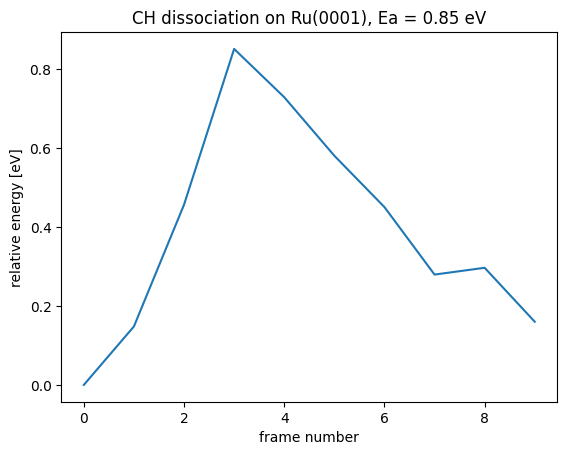

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")